In [1]:
from IPython.display import display,Image,clear_output
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import seaborn as sns
import random
import urllib.request
import h5py

from collections import Counter,defaultdict

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, InceptionV3
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import save_model

In [3]:
from keras import backend as K
K.backend()

'tensorflow'

In [4]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('vgg16_weights.h5', WEIGHTS_PATH_NO_TOP)

Defining input data

In [117]:
location = r'E:\code\Car_damage_evaluation\car-damage-dataset\data1a'
top_model_weights_path = os.path.join(location, 'top_model_weights.weights.h5')  # Update the file extension
fine_tuned_model_path = os.path.join(location, 'ft_model.keras')

# Image dimensions and data directories
img_width, img_height = 256, 256
train_data_dir = os.path.join(location, 'training')
val_data_dir = os.path.join(location, 'validation')

# Calculate samples in training and validation datasets
train_samples = [len(os.listdir(os.path.join(train_data_dir, i))) for i in os.listdir(train_data_dir)]
nb_train_samples = sum(train_samples)
val_samples = [len(os.listdir(os.path.join(val_data_dir, i))) for i in os.listdir(val_data_dir)]
nb_val_samples = sum(val_samples)

# Model settings
nb_epoch = 50
batch_size = 16



In [36]:
train_samples

[920, 920]

In [37]:
K.image_data_format()

'channels_last'

In [38]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3) 

In [39]:
input_shape

(256, 256, 3)

In [10]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=input_shape ,pooling=max)

In [11]:

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Set base_model layers to non-trainable
for layer in base_model.layers:
    layer.trainable=False

In [13]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [40]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [44]:
import traceback

def save_bottleneck_features(location):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    try:
        train_bottleneck_path = os.path.join(location, 'bottleneck_features_train.npy')
        if os.path.exists(train_bottleneck_path):
            print('Already exists:', train_bottleneck_path)
        else:
            train_generator = datagen.flow_from_directory(
                train_data_dir,
                target_size=(img_height, img_width),
                batch_size=batch_size,
                class_mode=None,
                shuffle=False
            )
            bottleneck_features_train = base_model.predict(train_generator, steps=nb_train_samples // batch_size, verbose=1)
            print('Saving:', train_bottleneck_path)
            np.save(train_bottleneck_path, bottleneck_features_train)
        
        val_bottleneck_path = os.path.join(location, 'bottleneck_features_val.npy')
        if os.path.exists(val_bottleneck_path):
            print('Already exists:', val_bottleneck_path)
        else:
            val_generator = datagen.flow_from_directory(
                val_data_dir,
                target_size=(img_height, img_width),
                batch_size=batch_size,
                class_mode=None,
                shuffle=False
            )
            bottleneck_features_val = base_model.predict(val_generator, steps=nb_val_samples // batch_size, verbose=1)
            print('Saving:', val_bottleneck_path)
            np.save(val_bottleneck_path, bottleneck_features_val)

    except Exception as e:
        print("An error occurred while saving bottleneck features:", e)
        traceback.print_exc()


In [45]:
val_labels = np.array([0]*val_samples[0] +
                          [1]*val_samples[1])

In [48]:
train_data = np.load(os.path.join(location, 'bottleneck_features_train.npy'))

In [49]:
train_data.shape

(1376, 8, 8, 512)

In [50]:
val_data = np.load(open(location+'/bottleneck_features_val.npy', 'rb'))
val_data.shape

(460, 8, 8, 512)

In [94]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import json
import os

def train_binary_model(location):
    # Load bottleneck features for training
    train_data = np.load(open(location+'/bottleneck_features_train.npy', 'rb'))
    print("Train data shape:", train_data.shape)  # Check the shape of train_data

    # Ensure the number of labels matches the number of training samples
    nb_train_samples = train_data.shape[0]
    print("Expected number of training labels:", nb_train_samples)

    # Correct label generation logic based on the correct number of samples
    # Here, adjust the number of labels for class 0 and class 1 according to the number of samples.
    # Example: if 1376 samples are split between classes 0 and 1, adjust as needed.
    # For example, if train_samples[0] = 688 and train_samples[1] = 688 for a 50/50 split:
    train_labels = np.array([0] * 688 + [1] * (nb_train_samples - 688))
    print("Train labels count:", len(train_labels))  # Check the length of train_labels

    if len(train_labels) != nb_train_samples:
        raise ValueError(f"Mismatch between data samples ({nb_train_samples}) and labels ({len(train_labels)})")

    # Load bottleneck features for validation
    val_data = np.load(open(location+'/bottleneck_features_val.npy', 'rb'))
    val_labels = np.array([0] * val_samples[0] + [1] * val_samples[1])

    # Check the number of validation samples and labels
    print("Validation data shape:", val_data.shape)
    print("Validation labels count:", len(val_labels))

    # Ensure the number of validation labels matches the number of validation data samples
    if len(val_labels) != val_data.shape[0]:
        raise ValueError(f"Mismatch between validation data samples and labels")

    # Build the model
    model = Sequential()
    model.add(Flatten(input_shape=(train_data.shape[1:])))
    model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Set the path for saving weights
    top_model_weights_path = os.path.join(location, 'top_model_weights.weights.h5')
    checkpoint = ModelCheckpoint(top_model_weights_path,
                                 monitor='val_accuracy', verbose=1,
                                 save_best_only=True, save_weights_only=True,
                                 mode='auto')

    # Train the model
    fit = model.fit(train_data, train_labels, epochs=nb_epoch, batch_size=16,
                    validation_data=(val_data, val_labels), callbacks=[checkpoint])

    with open(location + '/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [76]:
from tensorflow.keras.layers import Input

top_model = Sequential()
top_model.add(Input(shape=base_model.output_shape[1:]))
top_model.add(Flatten())
top_model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.01)))
top_model.add(Dropout(rate=0.5))
top_model.add(Dense(units=1, activation='sigmoid'))

    
top_model.load_weights(top_model_weights_path) # load weights_path
    
#base_model.add(top_model)
    
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
print(model.layers[-1].get_weights())
print(top_model.get_weights())
model.summary()

[array([[-0.01012065, -0.01048303,  0.0032335 , ...,  0.00972222,
        -0.01335548, -0.01087625],
       [ 0.00905526, -0.00504446, -0.00211019, ...,  0.00015012,
        -0.00304197,  0.00717667],
       [ 0.01050402, -0.00598194,  0.01128646, ...,  0.00608847,
         0.00694825, -0.00326765],
       ...,
       [ 0.00228057,  0.00289785, -0.00409706, ..., -0.0096005 ,
        -0.01046735,  0.00817893],
       [-0.00052284, -0.00416786, -0.00747126, ..., -0.00335509,
         0.01101705, -0.00097601],
       [-0.00150657,  0.00663762, -0.00871113, ..., -0.00802929,
        -0.00821638, -0.00677615]], dtype=float32), array([-6.63930041e-05, -6.27243571e-05, -4.21339973e-05, -3.36487865e-05,
       -1.31908173e-05,  1.40916454e-04,  3.21922744e-05, -9.27699875e-05,
       -1.64583562e-05, -7.52625201e-05, -6.59315119e-05,  6.05078058e-05,
       -4.62493745e-06,  2.27251494e-05, -1.93112064e-05, -1.38478526e-05,
       -2.43670002e-05,  2.52712562e-05,  1.22849873e-04, -5.67450406e

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 1)              │     8,389,121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,103,809 (88.13 MB)

 Trainable params: 8,389,121 (32.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [119]:
def finetune_binary_model(location):
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.01)))
    top_model.add(Dropout(rate=0.5))
    top_model.add(Dense(units=1,activation='sigmoid'))
    
    top_model.load_weights(top_model_weights_path) # load weights_path
    
    #base_model.add(top_model)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    #model.add(top_model)
    
#     input1 = keras.layers.Input(shape=(16,))
#     x1 = keras.layers.Dense(8, activation='relu')(input1)
#     input2 = keras.layers.Input(shape=(32,))
#     x2 = keras.layers.Dense(8, activation='relu')(input2)
#     added = keras.layers.add([x1, x2])

#     out = keras.layers.Dense(4)(added)
#     model = keras.models.Model(inputs=[input1, input2], outputs=out)

#     # finetune
#     top_model = Sequential()
#     top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
#     top_model.add(Dense(256, activation='relu'))
#     top_model.add(Dropout(0.5))
#     top_model.add(Dense(6, activation='sigmoid'))
#     top_model.load_weights(top_model_weights_path)

#     model = Model(input= base_model.input, output= top_model(model.output))
#     model.add(top_model)

    
#     # set the first 25 layers (up to the last conv block)
#     # to non-trainable - weights will not be updated
#     for layer in model.layers[:25]:
#         layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(optimizer=SGD(learning_rate=0.00001, momentum=0.9),  # updated learning_rate argument
              loss='binary_crossentropy',
              metrics=['accuracy'])

    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=8,
                                                        class_mode='binary')   # categorical for multiclass
    
    test_generator = test_datagen.flow_from_directory(val_data_dir,
                                                      target_size=(img_height, img_width),
                                                      batch_size=8,
                                                      class_mode='binary',     # categorical for multiclass
                                                      shuffle=False)
    
    checkpoint = ModelCheckpoint(filepath=fine_tuned_model_path,
                             monitor='val_accuracy',  # Make sure to use 'val_accuracy'
                             verbose=1,
                             save_best_only=True,
                             mode='auto',
                             save_weights_only=False)
    
    # fine-tune the model
    fit = model.fit(train_generator,
                steps_per_epoch=nb_train_samples // 8,  # use integer division for steps_per_epoch
                epochs=10,
                validation_data=test_generator,
                validation_steps=nb_val_samples // 8,  # use integer division for validation_steps
                verbose=1,
                callbacks=[checkpoint])


#     model.fit_generator(
#     train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
#     verbose=2)
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [139]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_binary_model(model, directory):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    test_generator = test_datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=8,
        class_mode='binary',  # categorical for multiclass
        shuffle=False
    )
    
    # Automatically retrieve true labels from test_generator
    labels = test_generator.classes
    print("Length of true labels:", len(labels))
    
    # Generate predictions using the model
    predictions = model.predict(test_generator, verbose=1)
    
    # For binary classification, threshold predictions at 0.5
    pred_labels = [0 if i < 0.5 else 1 for i in predictions]
    print("Length of predicted labels:", len(pred_labels))
    
    # Check if the lengths of labels and predictions match
    if len(labels) != len(pred_labels):
        print("Mismatch in label lengths!")
        return None
    
    # Print classification report
    print()
    print(classification_report(labels, pred_labels))
    print()
    
    # Confusion matrix
    cm = confusion_matrix(labels, pred_labels)
    return cm


In [68]:
def view_images(img_dir,img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img,width=200))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [99]:
import numpy as np

def print_best_model_results(model_hist):
    # Use the correct key 'val_accuracy' instead of 'val_acc'
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('Epoch:', best_epoch + 1, 
          ', val_accuracy:', model_hist['val_accuracy'][best_epoch], 
          ', val_loss:', model_hist['val_loss'][best_epoch])


In [100]:
import matplotlib.pyplot as plt

def plot_metrics(hist, stop=50):  # stop -> number of data points in plot
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot training & validation accuracy values
    ax0.plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    ax0.plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    ax0.set_title('Accuracy')
    ax0.set_ylabel('Accuracy')
    ax0.set_xlabel('Epoch')
    ax0.legend(loc='lower right')

    # Plot training & validation loss values
    ax1.plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    ax1.plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Display best model results
    print("Best Model:")
    print_best_model_results(hist)


Testing Image Generation

In [71]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

img = load_img(path='./car-damage-dataset/data1a/training/00-damage/0354.JPEG')  # this is a PIL image
x = img_to_array(img)   # x shape (height,width,3)
x = x.reshape((1,)+x.shape)  # this is a numpy array of shape (1,height,width,3)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'preview/' directory
if not os.path.exists('./car-damage-dataset/data1a_preview'):
    os.makedirs('./car-damage-dataset/data1a_preview')
i = 0 
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='./car-damage-dataset/data1a_preview', save_prefix='damage_car',
                         save_format='jpeg'):
    i +=1
    if i > 30:
        break # otherwise the generator would loop indefinitely

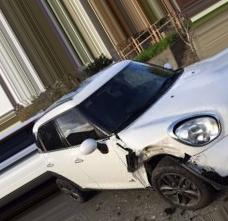

'Finished for now.'

In [72]:
view_images('./car-damage-dataset/data1a_preview/',os.listdir('./car-damage-dataset/data1a_preview'))

Training

In [73]:
save_bottleneck_features(location)

Already exists: E:\code\Car_damage_evaluation\car-damage-dataset\data1a\bottleneck_features_train.npy
Already exists: E:\code\Car_damage_evaluation\car-damage-dataset\data1a\bottleneck_features_val.npy


In [74]:
sns.set_style('whitegrid')

In [95]:
# Now run the function after defining it
d1a_model1, d1a_history1 = train_binary_model(location)

Train data shape: (1376, 8, 8, 512)
Expected number of training labels: 1376
Train labels count: 1376
Validation data shape: (460, 8, 8, 512)
Validation labels count: 460
Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5311 - loss: 5.7950
Epoch 1: val_accuracy improved from -inf to 0.50870, saving model to E:\code\Car_damage_evaluation\car-damage-dataset\data1a\top_model_weights.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.5317 - loss: 5.7945 - val_accuracy: 0.5087 - val_loss: 11.6053
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6704 - loss: 5.6459
Epoch 2: val_accuracy improved from 0.50870 to 0.53696, saving model to E:\code\Car_damage_evaluation\car-damage-dataset\data1a\top_model_weights.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.6706 - loss: 5.6458 - val_accuracy: 0.5370 - val_loss: 11.4294
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7442 - loss: 5.5756
Epoch 3: val_accuracy impro

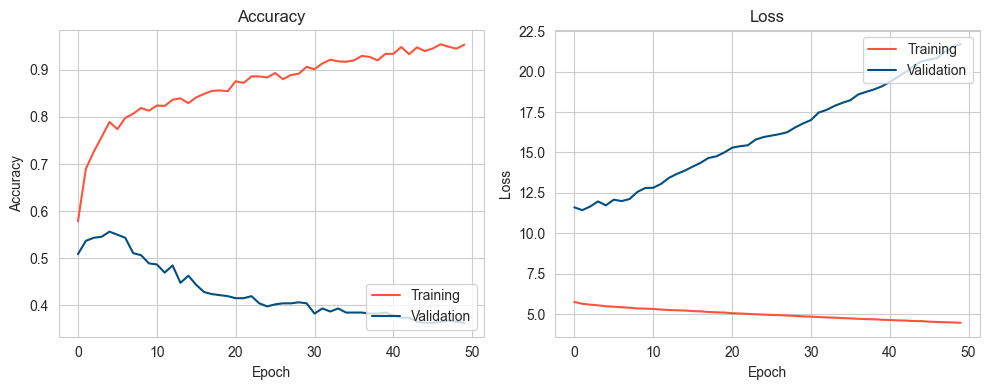

Best Model:
Epoch: 5 , val_accuracy: 0.5565217137336731 , val_loss: 11.727682113647461


In [101]:
plot_metrics(d1a_history1)

In [120]:
ft_model,ft_history = finetune_binary_model(location)

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


e:\code\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.6436 - loss: 9.5458
Epoch 1: val_accuracy improved from -inf to 0.79386, saving model to E:\code\Car_damage_evaluation\car-damage-dataset\data1a\ft_model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6440 - loss: 9.5390 - val_accuracy: 0.7939 - val_loss: 6.8466
Epoch 2/10


C:\Users\sombi\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_accuracy did not improve from 0.79386
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 5.2343
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.7805 - loss: 6.4145
Epoch 3: val_accuracy improved from 0.79386 to 0.87500, saving model to E:\code\Car_damage_evaluation\car-damage-dataset\data1a\ft_model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.7805 - loss: 6.4141 - val_accuracy: 0.8750 - val_loss: 5.5573
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.87500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 6.7124
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.8067 - loss: 6.1145
Epoch 5: val_accuracy did not improve from 0.87500
230/230 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8067 - loss: 6.1138 - val_accuracy: 0.8706 - val_loss: 5.4389
Epoch 6/10

Epoch 6: val_accu

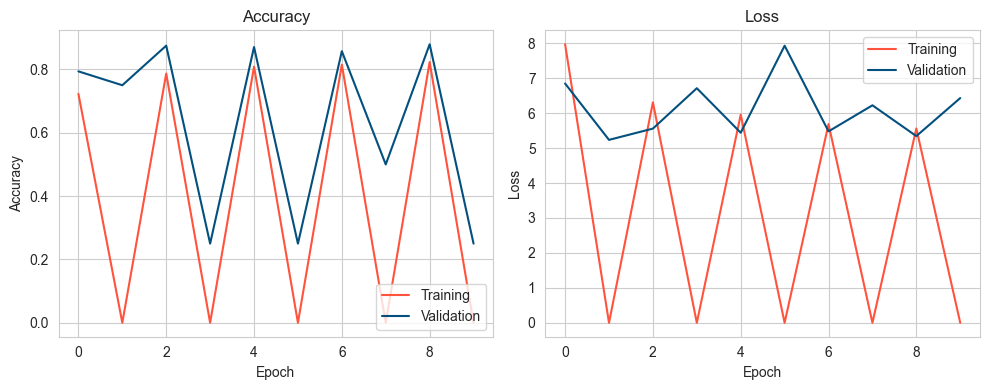

Best Model:
Epoch: 9 , val_accuracy: 0.8793859481811523 , val_loss: 5.342617511749268


In [121]:
plot_metrics(ft_history,stop=10) 

Load Modal Point

In [123]:
from tensorflow.keras.models import load_model

# Ensure 'location' holds the directory path where 'ft_model.h5' is saved
ft_model = load_model(location + '/ft_model.keras')


In [124]:
with open(location+'/top_history.txt') as f:
    top_history = json.load(f)

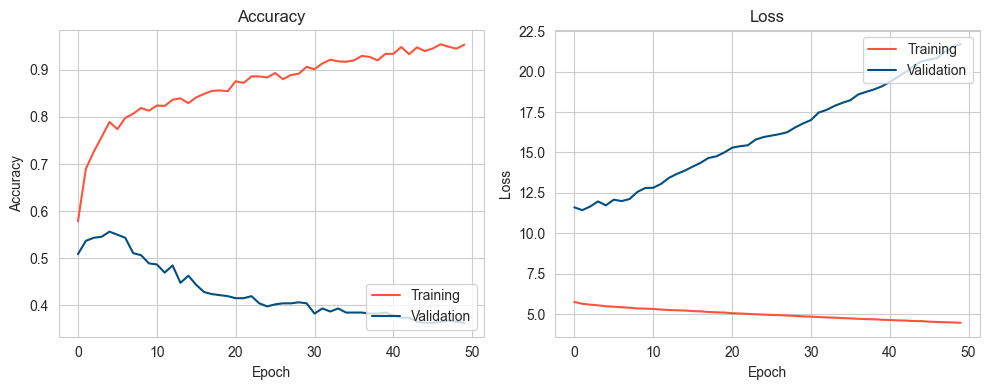

Best Model:
Epoch: 5 , val_accuracy: 0.5565217137336731 , val_loss: 11.727682113647461


In [125]:
plot_metrics(top_history)

In [126]:
with open(location+'/ft_history.txt') as f:
    ft_history = json.load(f)

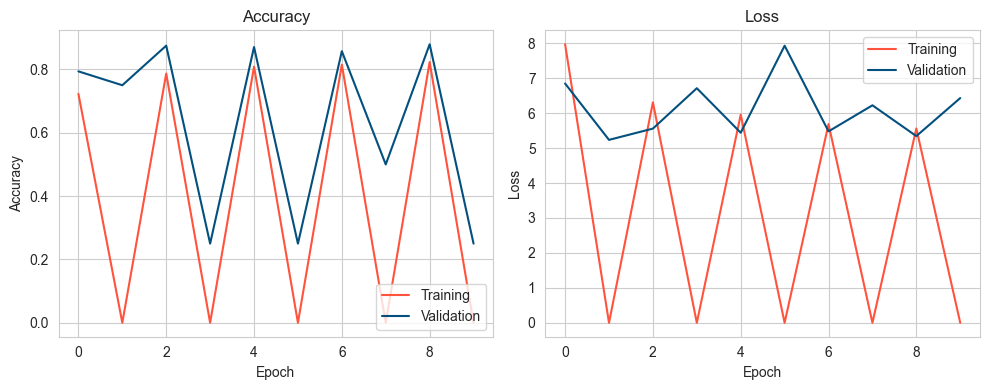

Best Model:
Epoch: 9 , val_accuracy: 0.8793859481811523 , val_loss: 5.342617511749268


In [127]:
plot_metrics(ft_history,stop=10)

In [130]:
def plot_acc_metrics(hist1, hist2, stop1=50, stop2=10):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 6))
    axes = axes.flatten()
    
    axes[0].plot(range(stop1), hist1['accuracy'], label='training', color='#FF533D')
    axes[0].plot(range(stop1), hist1['val_accuracy'], label='validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(range(stop2), hist2['accuracy'], label='training', color='#FF533D')
    axes[1].plot(range(stop2), hist2['val_accuracy'], label='validation', color='#03507E')
    axes[1].set_title('Fine-Tuning')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='lower right')
    
    plt.tight_layout()


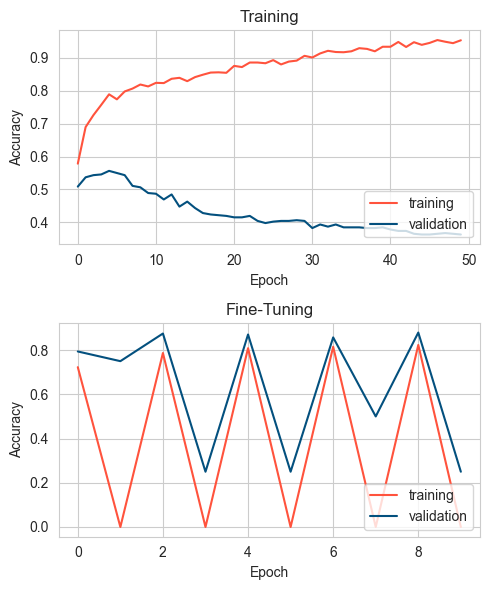

In [131]:
plot_acc_metrics(top_history,ft_history)

In [141]:
cm = evaluate_binary_model(ft_model,val_data_dir)

Found 460 images belonging to 2 classes.
Length of true labels: 460
58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 733ms/step
Length of predicted labels: 460

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       230
           1       0.83      0.94      0.88       230

    accuracy                           0.87       460
   macro avg       0.88      0.87      0.87       460
weighted avg       0.88      0.87      0.87       460




In [142]:
heatmap_labels = ['damaged','whole']

<Axes: >

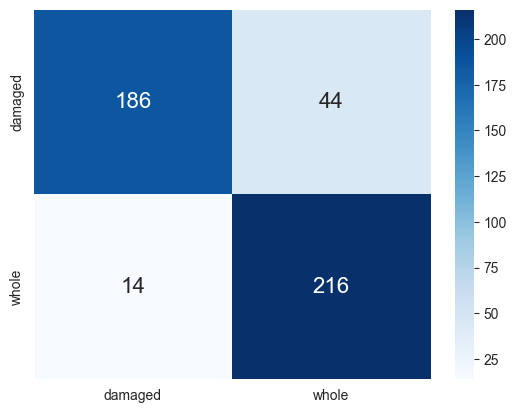

In [143]:

sns.heatmap(cm,annot=True,annot_kws={"size":16},
           fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

Making Live Predictions

In [144]:
def car_categories_gate(img_url,model):
    urllib.request.urlretrieve(img_url,'save_second_gate.jpg')
    img = load_img('save_second_gate.jpg',target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    pred = model.predict(x)
    print("Validating that damage exists...")
    #print(pred)
    if pred[0][0] <=.5:
        print("Validation complete - proceed to location and severity determination")
    else:
        print("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print("Hint: Try zooming in/out, using a different angle or different lighting")

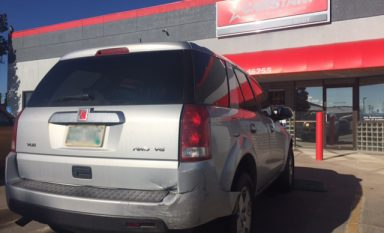

In [145]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [146]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Validating that damage exists...
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


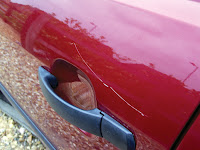

In [147]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [148]:
car_categories_gate('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Validating that damage exists...
Validation complete - proceed to location and severity determination


In [149]:
car_categories_gate('https://i.pinimg.com/originals/00/e2/d2/00e2d282c9d51424c5c3a96e9e649e37.jpg',ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Validating that damage exists...
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


Looking at edge cases

In [150]:
def get_edge_cases(model, directory, exp_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (256, 256, 3)
        x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 256, 256, 3)
        pred_prob = model.predict(x)
        if pred_prob[0][0] <=0.5:
            pred = 0
        else:
            pred = 1
#         print(pred_prob,pred,exp_result)
        if pred != exp_result:
            edge_list.append(name)
    return edge_list

In [152]:
evaluate_binary_model(ft_model, val_data_dir)

Found 460 images belonging to 2 classes.
Length of true labels: 460


e:\code\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 741ms/step
Length of predicted labels: 460

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       230
           1       0.83      0.94      0.88       230

    accuracy                           0.87       460
   macro avg       0.88      0.87      0.87       460
weighted avg       0.88      0.87      0.87       460




array([[186,  44],
       [ 14, 216]], dtype=int64)

In [153]:
fp = get_edge_cases(ft_model, location+'/validation/00-damage/', 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [154]:
len(fp)

14

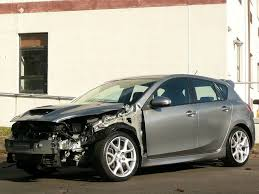

'Finished for now.'

In [155]:
view_images('./car-damage-dataset/data1a/validation/00-damage/', fp) 

In [156]:
fn = get_edge_cases(ft_model,location+'/validation/01-whole/', 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

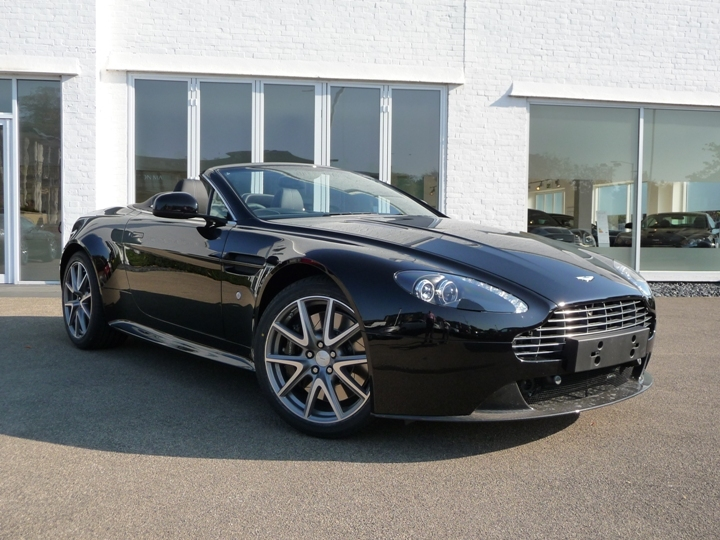

'Finished for now.'

In [157]:
view_images('./car-damage-dataset/data1a/validation/01-whole/', fn)  # whole, identifed as damage